<h2>Importing Libraries</h2>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import load_img
from tensorflow.keras.applications import ResNet50, DenseNet121, MobileNetV3Large
from sklearn.metrics import confusion_matrix, average_precision_score
#from selenium import webdriver
#from selenium.webdriver.common.keys import Keys
#from selenium.webdriver.common.by import By
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import matplotlib.pyplot as plt
import shutil
import random
import glob
import warnings
import os
import time
import requests
warnings.simplefilter(action='ignore', category=FutureWarning)

<h2>Checking For GPU Availability</h2>

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print('Num GPUs Available: ', len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


<h2>Data Preparation and Loading</h2>

In [ ]:
# Search images in gettyimages with Selenium
class_names = ["tundra-wolf","domestic-dog","italian-wolf","arctic-wolf","red-wolf"]
site = ["https://www.gettyimages.com/search/2/image-film?family=creative&phrase=tundra%20wolf",
      "https://www.gettyimages.com/search/2/image?phrase=domestic%20dog&sort=mostpopular&license=rf%2Crm",
      "https://www.gettyimages.com/search/2/image?phrase=italian%20wolf&sort=mostpopular&license=rf%2Crm",
      "https://www.gettyimages.com/search/2/image?phrase=arctic%20wolf&sort=mostpopular&license=rf%2Crm",
      "https://www.gettyimages.com/search/2/image?phrase=red%20wolf"]

os.chdir("C:/Users/Admin/Python/Mini/Wolf-Subspecies/datasets")# Move directory to download file there

cService = webdriver.ChromeService(executable_path='C:/Users/Admin/Downloads/chromedriver/chromedriver.exe')# Chromedriver path

# Creating a webdriver instance
driver = webdriver.Chrome(service = cService)

# Maximize the screen
driver.maximize_window()

for i in range(0,5):
    # Open url in the browser
    driver.get(site[i])
    # for image naming index
    index = 0

    # Going through 10 pages, as each page contains 60 images
    for p in range(0,10):
        # Class name and src of each image
        img_tag = driver.find_elements(By.CLASS_NAME,'Xc8V0Fvh0qg0lUySLpoi')
        img_url = [img.get_attribute('src') for img in img_tag if 'media.gettyimages' in img.get_attribute('src')]

        # download images
        for a, urls in enumerate(img_url[:60]):
            response = requests.get(urls, stream=True)
            index += 1
            with open(f'{class_names[i]} {index}.jpg','wb') as f:
                for chunk in response.iter_content(chunk_size=128):
                  f.write(chunk)

        try:# click on "Next" button to go to the next page
            driver.find_element(By.LINK_TEXT,'NEXT').click()

            # waiting for the results to load
            # Increase the sleep time if your internet is slow
            time.sleep(3)

        except:
            pass

# Finally, we close the driver
driver.close()

In [ ]:
for classes in class_names:
    if os.path.isdir('train/'+classes) is False:
        os.makedirs('train/'+classes)
        os.makedirs('valid/'+classes)
        os.makedirs('test/'+classes)

        for c in random.sample(glob.glob(classes+'*.jpg'),420):
            shutil.move(c, 'train/'+classes)
        for c in random.sample(glob.glob(classes+'*.jpg'),120):
            shutil.move(c, 'valid/'+classes)
        for c in random.sample(glob.glob(classes+'*.jpg'),60):
            shutil.move(c,'test/'+classes)

os.chdir('../../')

<h2>Continue in Google Colab</h2>

In [4]:
!apt-get install p7zip-full
!7z x /content/Wolf-Subspecies.zip -o/content/

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 122071474 bytes (117 MiB)

Extracting archive: /content/Wolf-Subspecies.zip
--
Path = /content/Wolf-Subspecies.zip
Type = zip
Physical Size = 122071474

  0%     13% 436 - Wolf-Subspecies/datasets/train/arctic-wolf/arctic-wolf 264.jpg                                                                          27% 8

In [5]:
train_path = '/content/Wolf-Subspecies/datasets/train'
valid_path = '/content/Wolf-Subspecies/datasets/valid'
test_path = '/content/Wolf-Subspecies/datasets/test'

<h3>Plot Confusion Matrix Function</h3>

In [60]:
import itertools
def plot_confusion_matrix(cm,classes,
                         normalize = False, title = 'Confusion Matrix',
                         cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks,classes)

    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i, cm[i,j],
                horizontalalignment='center',
                color='white' if cm[i,j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

<h1>ResNet50</h1>

In [10]:
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_batches_resnet50 = ImageDataGenerator(preprocessing_function=resnet_preprocess)\
    .flow_from_directory(
        directory=train_path,
        target_size=(224, 224),
        classes=['tundra-wolf', 'domestic-dog', 'italian-wolf', 'arctic-wolf', 'red-wolf'],
        batch_size=32
    )

valid_batches_resnet50 = ImageDataGenerator(preprocessing_function=resnet_preprocess)\
    .flow_from_directory(
        directory=valid_path,
        target_size=(224, 224),
        classes=['tundra-wolf', 'domestic-dog', 'italian-wolf', 'arctic-wolf', 'red-wolf'],
        batch_size=32
    )

test_batches_resnet50 = ImageDataGenerator(preprocessing_function=resnet_preprocess)\
    .flow_from_directory(
        directory=test_path,
        target_size=(224, 224),
        classes=['tundra-wolf', 'domestic-dog', 'italian-wolf', 'arctic-wolf', 'red-wolf'],
        batch_size=32,
        shuffle=False
    )

Found 2100 images belonging to 5 classes.
Found 600 images belonging to 5 classes.
Found 300 images belonging to 5 classes.


In [11]:
assert train_batches_resnet50.n == 2100
assert valid_batches_resnet50.n == 600
assert test_batches_resnet50.n == 300
assert train_batches_resnet50.num_classes == valid_batches_resnet50.num_classes == test_batches_resnet50.num_classes == 5

In [12]:
imgs_resnet50 , labels_resnet50 = next(train_batches_resnet50)

In [13]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize = (20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr,axes):
        img = (img - img.min()) / (img.max() - img.min())
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

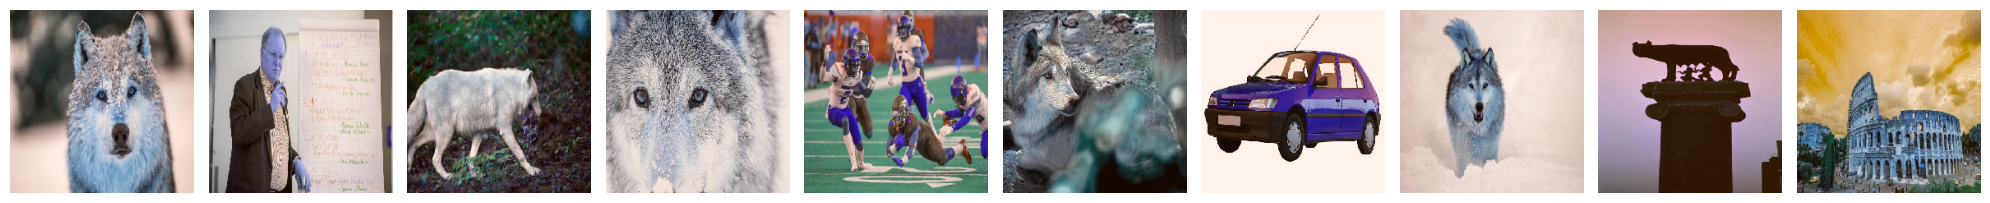

[[1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]


In [14]:
plotImages(imgs_resnet50)
print(labels_resnet50)

<h2>Training Model: ResNet50</h2>

In [15]:
#ResNet50 model
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
base_model_resnet.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [17]:
type(base_model_resnet)

keras.src.models.functional.Functional

In [23]:
from keras.layers import Dense, GlobalAveragePooling2D

resnet50_model = Sequential()

for layer in resnet50_model.layers:
    layer.trainable = False

resnet50_model.add(base_model_resnet)

resnet50_model.add(GlobalAveragePooling2D())

resnet50_model.add(Dense(units=5, activation='softmax'))


In [24]:
resnet50_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │          10,245 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,597,957 (90.02 MB)

 Trainable params: 23,544,837 (89.82 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [25]:
resnet50_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
start_time_resnet50 = time.time()

In [26]:
history_resnet50 = resnet50_model.fit(x=train_batches_resnet50, validation_data=valid_batches_resnet50, epochs=50, verbose=2)
training_time_resnet50 = time.time() - start_time_resnet50

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


66/66 - 130s - 2s/step - accuracy: 0.7757 - loss: 0.6146 - val_accuracy: 0.8067 - val_loss: 0.6797
Epoch 2/50
66/66 - 25s - 379ms/step - accuracy: 0.9676 - loss: 0.1196 - val_accuracy: 0.8300 - val_loss: 0.5332
Epoch 3/50
66/66 - 45s - 680ms/step - accuracy: 0.9871 - loss: 0.0524 - val_accuracy: 0.8500 - val_loss: 0.5305
Epoch 4/50
66/66 - 27s - 402ms/step - accuracy: 0.9910 - loss: 0.0349 - val_accuracy: 0.8683 - val_loss: 0.5010
Epoch 5/50
66/66 - 26s - 391ms/step - accuracy: 0.9924 - loss: 0.0256 - val_accuracy: 0.8667 - val_loss: 0.5266
Epoch 6/50
66/66 - 24s - 362ms/step - accuracy: 0.9929 - loss: 0.0195 - val_accuracy: 0.8633 - val_loss: 0.5486
Epoch 7/50
66/66 - 24s - 366ms/step - accuracy: 0.9905 - loss: 0.0196 - val_accuracy: 0.8633 - val_loss: 0.5566
Epoch 8/50
66/66 - 25s - 379ms/step - accuracy: 0.9895 - loss: 0.0175 - val_accuracy: 0.8667 - val_loss: 0.5726
Epoch 9/50
66/66 - 42s - 632ms/step - accuracy: 0.9905 - loss: 0.0139 - val_accuracy: 0.8600 - val_loss: 0.5815
Epoch

In [27]:
resnet50_model.save('/content/drive/MyDrive/resnet50_model.h5')
print("ResNet50 model saved to Google Drive!")

ResNet50 model saved to Google Drive!


In [28]:
resnet50_model.save('/content/drive/MyDrive/resnet50_model.keras')
print("ResNet50 model saved to Google Drive in Keras format!")

ResNet50 model saved to Google Drive in Keras format!


<h2>Model Accuracy: ResNet50 </h2>

In [144]:
from tensorflow.keras.models import load_model

# Load the model from the file
resnet50_model = load_model('/content/drive/MyDrive/resnet50_model.keras')


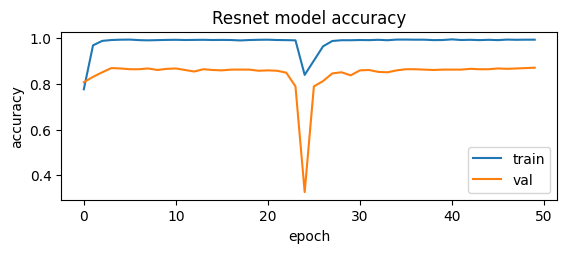

In [145]:
plt.subplot(2,1,1)
plt.plot(history_resnet50.history['accuracy'])
plt.plot(history_resnet50.history['val_accuracy'])
plt.title('Resnet model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')

<h2>Training Loss: ResNet50</h2>

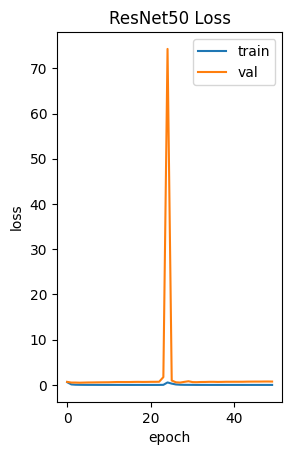

In [146]:
plt.subplot(1, 2, 2)
plt.plot(history_resnet50.history['loss'], label='Train')
plt.plot(history_resnet50.history['val_loss'], label='Validation')
plt.title('ResNet50 Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

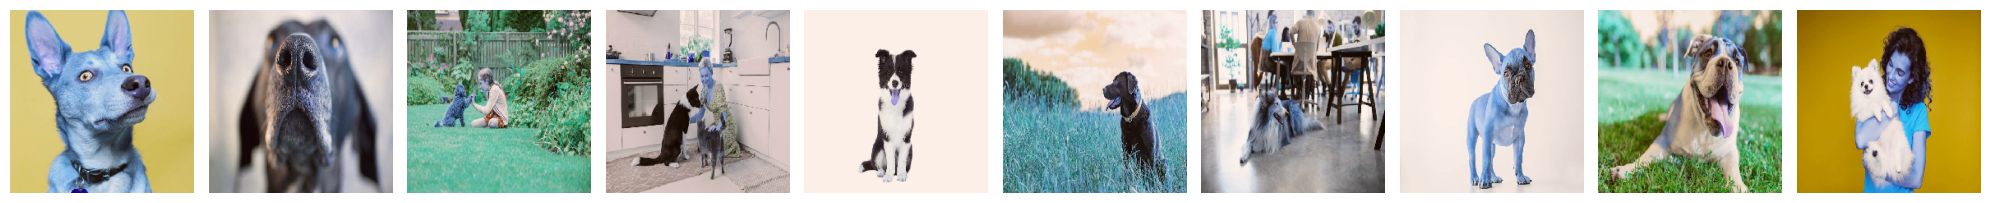

[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]]


In [147]:
test_imgs_resnet50, test_labels_resnet50 = next(test_batches_resnet50)
plotImages(test_imgs_resnet50)
print(test_labels_resnet50)

In [148]:
test_batches_resnet50.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], d

In [149]:
predictions_resnet50 = resnet50_model.predict(x=test_batches_resnet50, verbose=0)

In [150]:
np.round(predictions_resnet50)

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [151]:
cm_resnet50 = confusion_matrix(y_true=test_batches_resnet50.classes, y_pred=np.argmax(predictions_resnet50, axis=-1))

In [152]:
test_batches_resnet50.class_indices


{'tundra-wolf': 0,
 'domestic-dog': 1,
 'italian-wolf': 2,
 'arctic-wolf': 3,
 'red-wolf': 4}

Confusion matrix, without normalization
[[49  0  0 10  1]
 [ 0 58  0  2  0]
 [ 0  2 48  4  6]
 [ 8  0  3 49  0]
 [ 2  0  5  0 53]]


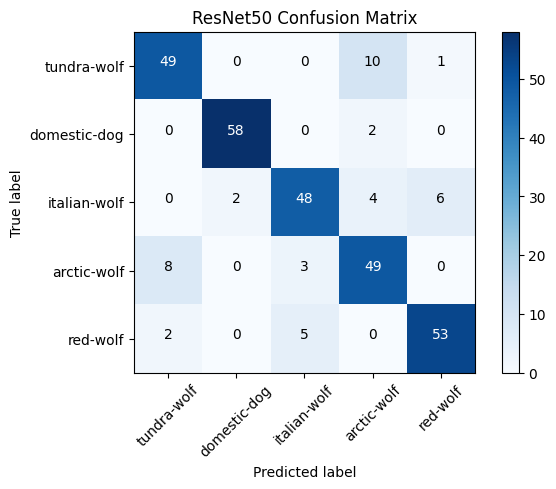

In [153]:
cm_plot_labels_resnet50 = ['tundra-wolf', 'domestic-dog', 'italian-wolf', 'arctic-wolf', 'red-wolf']
plot_confusion_matrix(cm=cm_resnet50, classes=cm_plot_labels_resnet50, title='ResNet50 Confusion Matrix')

In [154]:
loss_resnet50, acc_resnet50 = resnet50_model.evaluate(test_imgs_resnet50, test_labels_resnet50, batch_size=32)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.9688 - loss: 0.1185


In [155]:
print("Training time using ResNet50 model: " + str(training_time_resnet50 / 60) + " minute")

Training time using ResNet50 model: 30.03271230459213 minute


In [156]:
import numpy as np

# ResNet50 Confusion Matrix
confusion_matrix_resnet50 = np.array([
    [49,  0,  0, 10,  1],  # tundra-wolf
    [ 0, 58,  0,  2,  0],  # domestic-dog
    [ 0,  2, 48,  4,  6],  # italian-wolf
    [ 8,  0,  3, 49,  0],  # arctic-wolf
    [ 2,  0,  5,  0, 53]   # red-wolf
])

# Number of classes
num_classes = confusion_matrix_resnet50.shape[0]

# Initialize lists to store Precision, Recall, and F1-score for each class
precisions_resnet50 = []
recalls_resnet50 = []
f1_scores_resnet50 = []

# Calculate metrics for each class
for i in range(num_classes):
    TP = confusion_matrix_resnet50[i, i]  # True Positives
    FP = np.sum(confusion_matrix_resnet50[:, i]) - TP  # False Positives
    FN = np.sum(confusion_matrix_resnet50[i, :]) - TP  # False Negatives

    # Precision and Recall
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    # F1-score (AP for the class)
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Append to lists
    precisions_resnet50.append(precision)
    recalls_resnet50.append(recall)
    f1_scores_resnet50.append(f1_score)

# Calculate mean Average Precision (mAP)
mAP_resnet50 = np.mean(f1_scores_resnet50)

# Print results for ResNet50
print("Class-wise Precision (ResNet50):", precisions_resnet50)
print("Class-wise Recall (ResNet50):", recalls_resnet50)
print("Class-wise F1-scores (AP) (ResNet50):", f1_scores_resnet50)
print("Mean Average Precision (mAP) (ResNet50):", mAP_resnet50)


Class-wise Precision (ResNet50): [0.8305084745762712, 0.9666666666666667, 0.8571428571428571, 0.7538461538461538, 0.8833333333333333]
Class-wise Recall (ResNet50): [0.8166666666666667, 0.9666666666666667, 0.8, 0.8166666666666667, 0.8833333333333333]
Class-wise F1-scores (AP) (ResNet50): [0.8235294117647058, 0.9666666666666667, 0.8275862068965518, 0.784, 0.8833333333333333]
Mean Average Precision (mAP) (ResNet50): 0.8570231237322513


<h1>DenseNet121</h1>

In [41]:
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess

train_batches_densenet121 = ImageDataGenerator(preprocessing_function=densenet_preprocess)\
    .flow_from_directory(
        directory=train_path,
        target_size=(224, 224),
        classes=['tundra-wolf', 'domestic-dog', 'italian-wolf', 'arctic-wolf', 'red-wolf'],
        batch_size=32
    )

valid_batches_densenet121 = ImageDataGenerator(preprocessing_function=densenet_preprocess)\
    .flow_from_directory(
        directory=valid_path,
        target_size=(224, 224),
        classes=['tundra-wolf', 'domestic-dog', 'italian-wolf', 'arctic-wolf', 'red-wolf'],
        batch_size=32
    )

test_batches_densenet121 = ImageDataGenerator(preprocessing_function=densenet_preprocess)\
    .flow_from_directory(
        directory=test_path,
        target_size=(224, 224),
        classes=['tundra-wolf', 'domestic-dog', 'italian-wolf', 'arctic-wolf', 'red-wolf'],
        batch_size=32,
        shuffle=False
    )

Found 2100 images belonging to 5 classes.
Found 600 images belonging to 5 classes.
Found 300 images belonging to 5 classes.


In [42]:
assert train_batches_densenet121.n == 2100
assert valid_batches_densenet121.n == 600
assert test_batches_densenet121.n == 300
assert train_batches_densenet121.num_classes == valid_batches_densenet121.num_classes == test_batches_densenet121.num_classes == 5


In [43]:
imgs_densenet121 , labels_densenet121 = next(train_batches_densenet121)

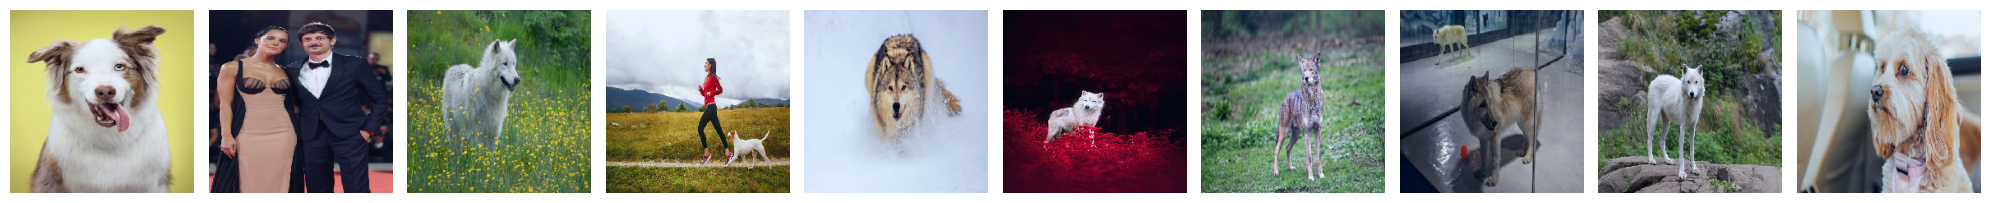

[[0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]]


In [44]:
plotImages(imgs_densenet121)
print(labels_densenet121)

<h2>Training Model: DenseNet121</h2>

In [45]:
# DenseNet121 Model
base_model_densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [46]:
base_model_densenet.summary()

Model: "densenet121"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer_2[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 6,953,856 (26.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [47]:
type(base_model_densenet)

keras.src.models.functional.Functional

In [48]:
densenet121_model = Sequential()

densenet121_model.add(base_model_densenet)

for layer in densenet121_model.layers:
    layer.trainable = False

densenet121_model.add(GlobalAveragePooling2D())

densenet121_model.add(Dense(units=5, activation='softmax'))

In [49]:
densenet121_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 7, 7, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           5,125 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,042,629 (26.87 MB)

 Trainable params: 5,125 (20.02 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [50]:
densenet121_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
start_time_densenet121 = time.time()

In [51]:
history_densenet121 = densenet121_model.fit(x=train_batches_densenet121, validation_data=valid_batches_densenet121, epochs=50, verbose=2)
training_time_densenet121 = time.time() - start_time_densenet121

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


66/66 - 75s - 1s/step - accuracy: 0.2852 - loss: 1.9083 - val_accuracy: 0.2800 - val_loss: 1.6583
Epoch 2/50
66/66 - 16s - 246ms/step - accuracy: 0.3962 - loss: 1.4443 - val_accuracy: 0.4433 - val_loss: 1.3618
Epoch 3/50
66/66 - 16s - 246ms/step - accuracy: 0.5262 - loss: 1.2013 - val_accuracy: 0.5617 - val_loss: 1.1790
Epoch 4/50
66/66 - 18s - 272ms/step - accuracy: 0.5990 - loss: 1.0469 - val_accuracy: 0.5950 - val_loss: 1.0560
Epoch 5/50
66/66 - 20s - 307ms/step - accuracy: 0.6424 - loss: 0.9419 - val_accuracy: 0.6367 - val_loss: 0.9695
Epoch 6/50
66/66 - 16s - 244ms/step - accuracy: 0.6810 - loss: 0.8621 - val_accuracy: 0.6633 - val_loss: 0.9084
Epoch 7/50
66/66 - 16s - 246ms/step - accuracy: 0.7005 - loss: 0.8054 - val_accuracy: 0.6867 - val_loss: 0.8563
Epoch 8/50
66/66 - 20s - 310ms/step - accuracy: 0.7233 - loss: 0.7568 - val_accuracy: 0.7050 - val_loss: 0.8154
Epoch 9/50
66/66 - 17s - 258ms/step - accuracy: 0.7443 - loss: 0.7152 - val_accuracy: 0.7067 - val_loss: 0.7809
Epoch 

In [52]:
# Or save it to Google Drive
densenet121_model.save('/content/drive/MyDrive/densenet121_model.h5')
print("DenseNet121 model saved to Google Drive!")

densenet121_model.save('/content/drive/MyDrive/densenet121_model.keras')
print("DenseNet121 model saved to Google Drive in Keras format!")

DenseNet121 model saved to Google Drive!
DenseNet121 model saved to Google Drive in Keras format!


<h2>Model Accuracy: DenseNet121</h2>

In [174]:
from tensorflow.keras.models import load_model

# Load the model from the file
densenet121_model = load_model('/content/drive/MyDrive/densenet121_model.keras')


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 4 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


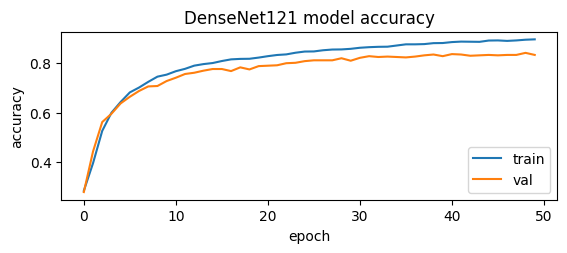

In [175]:
plt.subplot(2,1,1)
plt.plot(history_densenet121.history['accuracy'])
plt.plot(history_densenet121.history['val_accuracy'])
plt.title('DenseNet121 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')

<h2>Training Loss: DenseNet121</h2>

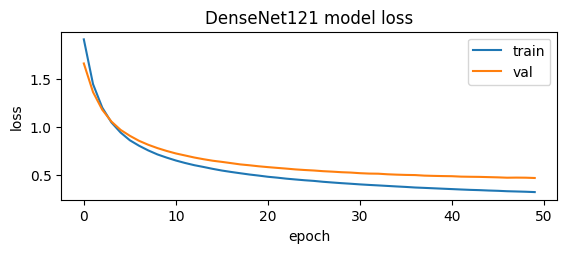

In [176]:
plt.subplot(2,1,2)
plt.plot(history_densenet121.history['loss'])
plt.plot(history_densenet121.history['val_loss'])
plt.title('DenseNet121 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

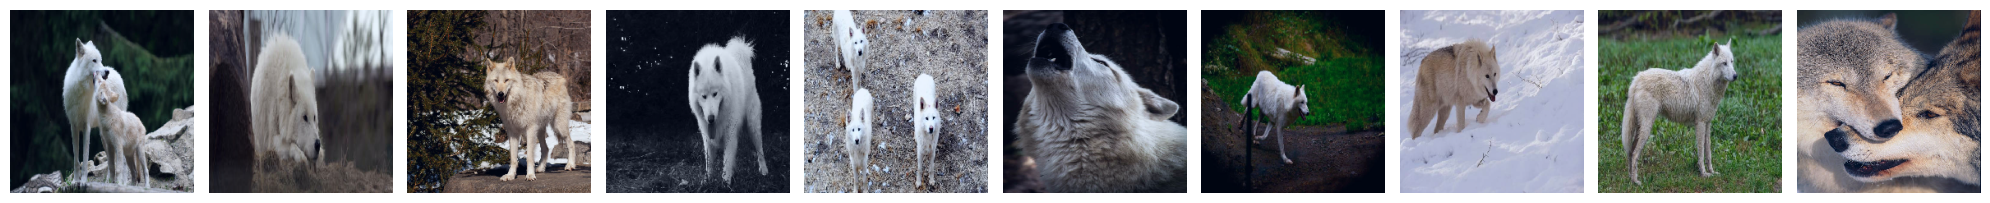

[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]


In [177]:
test_imgs_densenet121, test_labels_densenet121 = next(test_batches_densenet121)
plotImages(test_imgs_densenet121)
print(test_labels_densenet121)

In [178]:
test_batches_densenet121.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], d

In [166]:
predictions_densenet121 = densenet121_model.predict(x=test_batches_densenet121, verbose=0)

In [167]:
np.round(predictions_densenet121)

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [168]:
from sklearn.metrics import confusion_matrix

cm_densenet121 = confusion_matrix(y_true=test_batches_densenet121.classes, y_pred=np.argmax(predictions_densenet121, axis=-1))

In [179]:
test_batches_densenet121.class_indices

{'tundra-wolf': 0,
 'domestic-dog': 1,
 'italian-wolf': 2,
 'arctic-wolf': 3,
 'red-wolf': 4}

Confusion matrix, without normalization
[[39  0  2 17  2]
 [ 0 57  2  0  1]
 [ 0  1 45  2 12]
 [ 8  0  1 49  2]
 [ 0  2  7  2 49]]


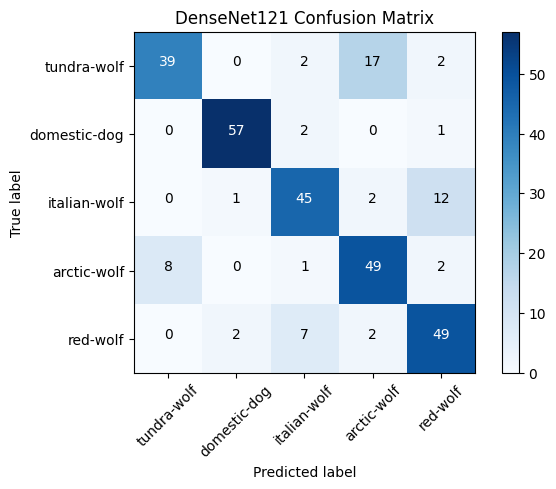

In [180]:
cm_plot_labels_densenet121 = ['tundra-wolf', 'domestic-dog', 'italian-wolf', 'arctic-wolf', 'red-wolf']
plot_confusion_matrix(cm=cm_densenet121, classes=cm_plot_labels_densenet121, title='DenseNet121 Confusion Matrix')

In [181]:
loss_densenet121, acc_densenet121 = densenet121_model.evaluate(test_imgs_densenet121, test_labels_densenet121, batch_size=32)

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.7812 - loss: 0.6119


In [182]:
print("Training time using DenseNet121 model: " + str(training_time_densenet121 / 60) + " minute")

Training time using DenseNet121 model: 15.99098664522171 minute


In [183]:
# Confusion matrix for Densenet121
confusion_matrix_densenet121 = np.array([
    [39,  0,  2, 17,  2],  # Tundra-wolf
    [ 0, 57,  2,  0,  1],  # Domestic-dog
    [ 0,  1, 45,  2, 12],  # Italian-wolf
    [ 8,  0,  1, 49,  2],  # Arctic-wolf
    [ 0,  2,  7,  2, 49]   # Red-wolf
])

# Number of classes
num_classes = confusion_matrix_densenet121.shape[0]

# Initialize lists to store precision, recall, and AP for each class
precisions_densenet121 = []
recalls_densenet121 = []
average_precisions_densenet121 = []

# Calculate precision, recall, and AP for each class
for i in range(num_classes):
    TP = confusion_matrix_densenet121[i, i]  # True Positives
    FP = np.sum(confusion_matrix_densenet121[:, i]) - TP  # False Positives
    FN = np.sum(confusion_matrix_densenet121[i, :]) - TP  # False Negatives

    # Precision and Recall
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    # Store precision and recall
    precisions_densenet121.append(precision)
    recalls_densenet121.append(recall)

    # Average Precision (AP) as the average of precision and recall
    AP = (precision + recall) / 2
    average_precisions_densenet121.append(AP)

# Calculate mean Average Precision (mAP)
mAP_densenet121 = np.mean(average_precisions_densenet121)

# Print results
print("Class-wise Precision for Densenet121:", precisions_densenet121)
print("Class-wise Recall for Densenet121:", recalls_densenet121)
print("Class-wise Average Precision (AP) for Densenet121:", average_precisions_densenet121)
print("Mean Average Precision (mAP) for Densenet121:", mAP_densenet121)


Class-wise Precision for Densenet121: [0.8297872340425532, 0.95, 0.7894736842105263, 0.7, 0.7424242424242424]
Class-wise Recall for Densenet121: [0.65, 0.95, 0.75, 0.8166666666666667, 0.8166666666666667]
Class-wise Average Precision (AP) for Densenet121: [0.7398936170212767, 0.95, 0.7697368421052632, 0.7583333333333333, 0.7795454545454545]
Mean Average Precision (mAP) for Densenet121: 0.7995018494010655


<h1>MobileNetV3</h1>

In [67]:
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as mobilenet_preprocess

train_batches_mobilenetv3 = ImageDataGenerator(preprocessing_function=mobilenet_preprocess)\
    .flow_from_directory(
        directory=train_path,
        target_size=(224, 224),
        classes=['tundra-wolf', 'domestic-dog', 'italian-wolf', 'arctic-wolf', 'red-wolf'],
        batch_size=32
    )

valid_batches_mobilenetv3 = ImageDataGenerator(preprocessing_function=mobilenet_preprocess)\
    .flow_from_directory(
        directory=valid_path,
        target_size=(224, 224),
        classes=['tundra-wolf', 'domestic-dog', 'italian-wolf', 'arctic-wolf', 'red-wolf'],
        batch_size=32
    )

test_batches_mobilenetv3 = ImageDataGenerator(preprocessing_function=mobilenet_preprocess)\
    .flow_from_directory(
        directory=test_path,
        target_size=(224, 224),
        classes=['tundra-wolf', 'domestic-dog', 'italian-wolf', 'arctic-wolf', 'red-wolf'],
        batch_size=32,
        shuffle=False
    )

Found 2100 images belonging to 5 classes.
Found 600 images belonging to 5 classes.
Found 300 images belonging to 5 classes.


In [68]:
assert train_batches_mobilenetv3.n == 2100
assert valid_batches_mobilenetv3.n == 600
assert test_batches_mobilenetv3.n == 300
assert train_batches_mobilenetv3.num_classes == valid_batches_mobilenetv3.num_classes == test_batches_mobilenetv3.num_classes == 5


In [69]:
imgs_mobilenetv3 , labels_mobilenetv3 = next(train_batches_mobilenetv3)

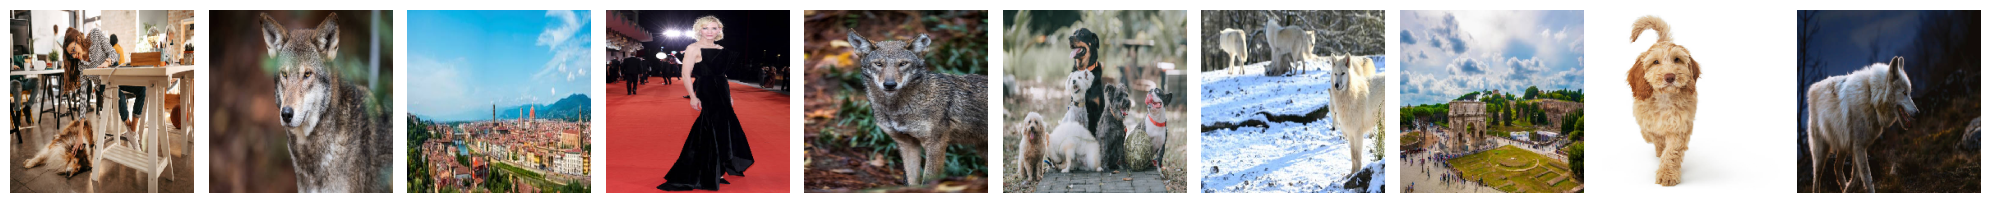

[[0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]


In [70]:
plotImages(imgs_mobilenetv3)
print(labels_mobilenetv3)

<h2>Training Model: MobileNetV3</h2>

In [71]:
# MobileNetV3 Model
base_model_mobilenetv3 = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [72]:
base_model_mobilenetv3.summary()

Model: "MobileNetV3Large"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv (Conv2D)             │ (None, 112, 112, 16)   │            432 │ rescaling[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_bn                   │ (None, 112, 112, 16)   │             64 │ conv[0][0]             │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 112, 112, 16)   │              0 │ conv_bn[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 16)   │            144 │ activation[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 16)   │             64 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 112, 112, 16)   │              0 │ expanded_conv_depthwi… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            256 │ re_lu[0][0]            │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_bn  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_add (Add)   │ (None, 112, 112, 16)   │              0 │ activation[0][0],      │
│                           │                        │                │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_1_expand    │ (None, 112, 112, 64)   │          1,024 │ expanded_conv_add[0][… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_1_expand_bn │ (None, 112, 112, 64)   │            256 │ expanded_conv_1_expan… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 112, 112, 64)   │              0 │ expanded_conv_1_expan… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_1_depthwis… │ (None, 113, 113, 64)   │              0 │ re_lu_1[0][0]          │
│ (ZeroPadding2D)      

 Total params: 2,996,352 (11.43 MB)

 Trainable params: 2,971,952 (11.34 MB)

 Non-trainable params: 24,400 (95.31 KB)

In [73]:
type(base_model_mobilenetv3)

keras.src.models.functional.Functional

In [74]:
mobilenetv3_model = Sequential([
    base_model_mobilenetv3,
    GlobalAveragePooling2D(),
    Dense(units=5, activation='softmax')
])

for layer in mobilenetv3_model.layers:
    layer.trainable = False

mobilenetv3_model.add(Dense(units=5, activation='softmax'))

In [75]:
mobilenetv3_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ MobileNetV3Large (Functional)        │ (None, 7, 7, 960)           │       2,996,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 960)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │           4,805 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │              30 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,001,187 (11.45 MB)

 Trainable params: 30 (120.00 B)

 Non-trainable params: 3,001,157 (11.45 MB)

In [76]:
mobilenetv3_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
start_time_mobilenetv3 = time.time()

In [77]:
history_mobilenetv3 = mobilenetv3_model.fit(x=train_batches_mobilenetv3, validation_data=valid_batches_mobilenetv3, epochs=50, verbose=2)
training_time_mobilenetv3 = time.time() - start_time_mobilenetv3

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


66/66 - 53s - 810ms/step - accuracy: 0.2000 - loss: 1.6764 - val_accuracy: 0.2000 - val_loss: 1.6761
Epoch 2/50
66/66 - 15s - 227ms/step - accuracy: 0.2000 - loss: 1.6737 - val_accuracy: 0.2000 - val_loss: 1.6734
Epoch 3/50
66/66 - 22s - 331ms/step - accuracy: 0.2000 - loss: 1.6709 - val_accuracy: 0.2000 - val_loss: 1.6707
Epoch 4/50
66/66 - 17s - 258ms/step - accuracy: 0.2000 - loss: 1.6683 - val_accuracy: 0.2000 - val_loss: 1.6681
Epoch 5/50
66/66 - 17s - 265ms/step - accuracy: 0.2000 - loss: 1.6657 - val_accuracy: 0.2000 - val_loss: 1.6655
Epoch 6/50
66/66 - 14s - 209ms/step - accuracy: 0.2000 - loss: 1.6631 - val_accuracy: 0.2000 - val_loss: 1.6630
Epoch 7/50
66/66 - 21s - 312ms/step - accuracy: 0.2000 - loss: 1.6606 - val_accuracy: 0.1983 - val_loss: 1.6607
Epoch 8/50
66/66 - 15s - 225ms/step - accuracy: 0.2000 - loss: 1.6582 - val_accuracy: 0.1983 - val_loss: 1.6583
Epoch 9/50
66/66 - 14s - 208ms/step - accuracy: 0.2000 - loss: 1.6559 - val_accuracy: 0.1983 - val_loss: 1.6560
Epo

In [78]:
# Or save it to Google Drive
mobilenetv3_model.save('/content/drive/MyDrive/mobilenetv3_model.h5')
print("DenseNet121 model saved to Google Drive!")

mobilenetv3_model.save('/content/drive/MyDrive/mobilenetv3_model.keras')
print("MobileNetV3 model saved to Google Drive in Keras format!")

DenseNet121 model saved to Google Drive!
MobileNetV3 model saved to Google Drive in Keras format!


<h2>Model Accuracy: MobileNetV3</h2>

In [184]:
from tensorflow.keras.models import load_model

# Load the model from the file
mobilenetv3_model = load_model('/content/drive/MyDrive/mobilenetv3_model.keras')


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 4 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


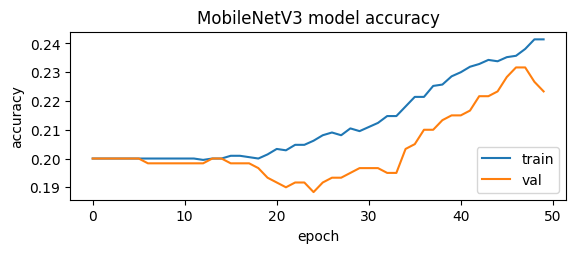

In [185]:
plt.subplot(2,1,1)
plt.plot(history_mobilenetv3.history['accuracy'])
plt.plot(history_mobilenetv3.history['val_accuracy'])
plt.title('MobileNetV3 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')

<h2>Training Loss: MobileNetV3</h2>

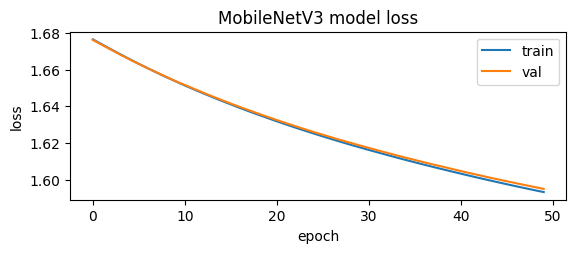

In [186]:
plt.subplot(2,1,2)
plt.plot(history_mobilenetv3.history['loss'])
plt.plot(history_mobilenetv3.history['val_loss'])
plt.title('MobileNetV3 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

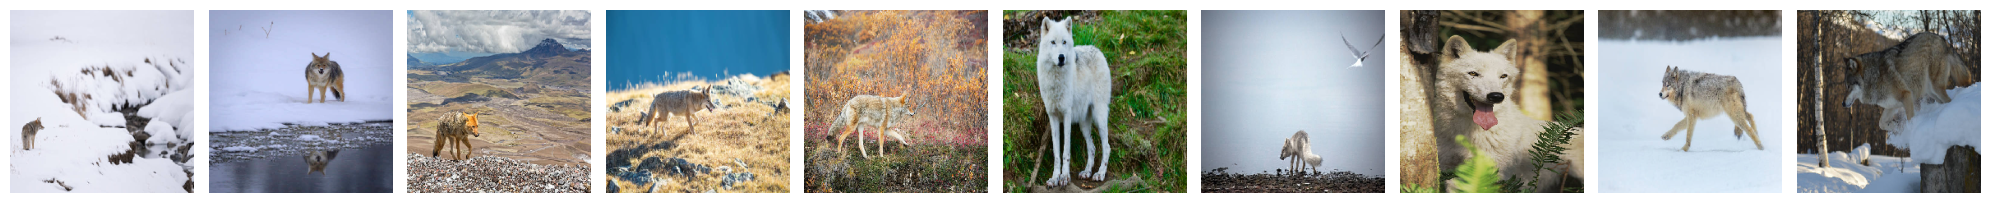

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


In [187]:
test_imgs_mobilenetv3, test_labels_mobilenetv3 = next(test_batches_mobilenetv3)
plotImages(test_imgs_mobilenetv3)
print(test_labels_mobilenetv3)

In [188]:
test_batches_mobilenetv3.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], d

In [189]:
predictions_mobilenetv3 = mobilenetv3_model.predict(x=test_batches_mobilenetv3, verbose=0)

In [190]:
np.round(predictions_mobilenetv3)

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]], dtype=float32)

In [191]:
cm_mobilenetv3 = confusion_matrix(y_true=test_batches_mobilenetv3.classes, y_pred=np.argmax(predictions_mobilenetv3, axis=-1))

In [192]:
test_batches_mobilenetv3.class_indices

{'tundra-wolf': 0,
 'domestic-dog': 1,
 'italian-wolf': 2,
 'arctic-wolf': 3,
 'red-wolf': 4}

Confusion matrix, without normalization
[[ 0 15  2  0 43]
 [ 0 16 25  0 19]
 [ 0  7 10  0 43]
 [ 0 12  3  0 45]
 [ 0  5 10  0 45]]


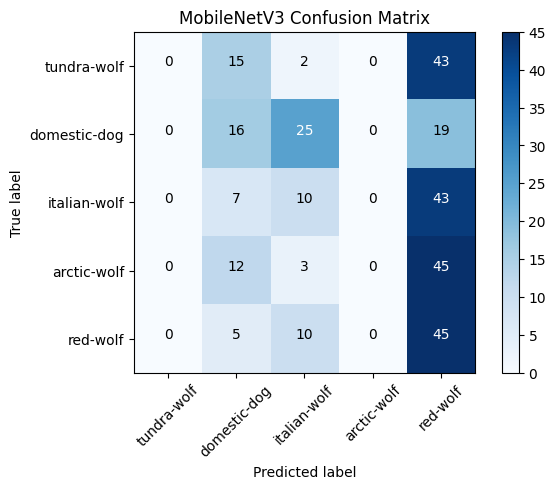

In [193]:
cm_plot_labels_mobilenetv3 = ['tundra-wolf', 'domestic-dog', 'italian-wolf', 'arctic-wolf', 'red-wolf']
plot_confusion_matrix(cm=cm_mobilenetv3, classes=cm_plot_labels_mobilenetv3, title='MobileNetV3 Confusion Matrix')

In [194]:
loss_mobilenetv3, acc_mobilenetv3 = mobilenetv3_model.evaluate(test_imgs_mobilenetv3, test_labels_mobilenetv3, batch_size=32)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.0625 - loss: 1.6548


In [195]:
print("Training time using MobileNetV3 model: " + str(training_time_mobilenetv3/60) + "minutes")

Training time using MobileNetV3 model: 14.394516936937968minutes


In [196]:
# Confusion matrix for MobileNetV3
confusion_matrix_mobilenetv3 = np.array([
    [ 0, 15,  2,  0, 43],  # Tundra-wolf
    [ 0, 16, 25,  0, 19],  # Domestic-dog
    [ 0,  7, 10,  0, 43],  # Italian-wolf
    [ 0, 12,  3,  0, 45],  # Arctic-wolf
    [ 0,  5, 10,  0, 45]   # Red-wolf
])

# Number of classes
num_classes = confusion_matrix_mobilenetv3.shape[0]

# Initialize lists to store precision, recall, and AP for each class
precisions_mobilenetv3 = []
recalls_mobilenetv3 = []
average_precisions_mobilenetv3 = []

# Calculate precision, recall, and AP for each class
for i in range(num_classes):
    TP = confusion_matrix_mobilenetv3[i, i]  # True Positives
    FP = np.sum(confusion_matrix_mobilenetv3[:, i]) - TP  # False Positives
    FN = np.sum(confusion_matrix_mobilenetv3[i, :]) - TP  # False Negatives

    # Precision and Recall
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    # Store precision and recall
    precisions_mobilenetv3.append(precision)
    recalls_mobilenetv3.append(recall)

    # Average Precision (AP) as the average of precision and recall
    AP = (precision + recall) / 2
    average_precisions_mobilenetv3.append(AP)

# Calculate mean Average Precision (mAP)
mAP_mobilenetv3 = np.mean(average_precisions_mobilenetv3)

# Print results
print("Class-wise Precision for MobileNetV3:", precisions_mobilenetv3)
print("Class-wise Recall for MobileNetV3:", recalls_mobilenetv3)
print("Class-wise Average Precision (AP) for MobileNetV3:", average_precisions_mobilenetv3)
print("Mean Average Precision (mAP) for MobileNetV3:", mAP_mobilenetv3)


Class-wise Precision for MobileNetV3: [0, 0.2909090909090909, 0.2, 0, 0.23076923076923078]
Class-wise Recall for MobileNetV3: [0.0, 0.26666666666666666, 0.16666666666666666, 0.0, 0.75]
Class-wise Average Precision (AP) for MobileNetV3: [0.0, 0.2787878787878788, 0.18333333333333335, 0.0, 0.4903846153846154]
Mean Average Precision (mAP) for MobileNetV3: 0.19050116550116553


# Conclusion

Based on the conclusion, **ResNet50** is the best model suited for this classification task. The reason is because:




*   **Accuracy**: ResNet50 achieved the highest test accuracy at 96.88%, significantly outperforming DenseNet121 (78.12%) and MobileNetV3 (6.25%).

*   **Loss**: ResNet50 had the lowest loss value of 0.1185, compared to DenseNet121’s 0.6119 and MobileNetV3’s 1.6548, indicating better model performance.

*   **mAP**: ResNet50 achieved a higher mAP of 85.70%, compared to DenseNet121's 79.95% and MobileNetV3's 19.05%, showcasing better precision across all classes.

*   **Training Time**: While ResNet50 required 28.5 minutes to train, this was only slightly more than MobileNetV3's 14.39 minutes and slightly less than DenseNet121's 32.15 minutes. The additional time is justified by its superior accuracy and lower loss.

*   **Class-wise Metrics**:ResNet50 consistently performed better in class-wise precision, recall, and F1 scores compared to the other models.


In conclusion, ResNet50 demonstrates the best balance between accuracy, loss, and mAP while maintaining reasonable training time, making it the most suitable model for this classification task.




